In [1]:
import gym
import numpy as np
from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
from gym import spaces
import pybullet as p
from collections import defaultdict
import torch.optim as optim
from collections import deque
import timeit
from matplotlib import pyplot as plt

current_dir=/home/monster/anaconda3/envs/python36/lib/python3.6/site-packages/pybullet_envs/bullet


In [2]:
env = KukaDiverseObjectEnv(renders=True, isDiscrete=False, removeHeightHack=True, maxSteps=20)
env.cid = p.connect(p.DIRECT)
action_space = spaces.Box(low=-1, high=1, shape=(5, 1))

Actor-Critic implementation

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def build_hidden_layer(input_dim, hidden_layers):
    """Build hidden layer.
    Params
    ======
        input_dim (int): Dimension of hidden layer input
        hidden_layers (list(int)): Dimension of hidden layers
    """
    hidden = nn.ModuleList([nn.Linear(input_dim, hidden_layers[0])])
    if len(hidden_layers)>1:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        hidden.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
    return hidden

def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class ActorCritic(nn.Module):
    def __init__(self,state_size,action_size,channel_size,
                 critic_hidden_layers=[],actor_hidden_layers=[],
                 seed=0, init_type=None):
        """Initialize parameters and build policy.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            shared_layers (list(int)): Dimension of the shared hidden layers
            critic_hidden_layers (list(int)): Dimension of the critic's hidden layers
            actor_hidden_layers (list(int)): Dimension of the actor's hidden layers
            seed (int): Random seed
            init_type (str): Initialization type
        """
        super(ActorCritic, self).__init__()
        self.init_type = init_type
        self.seed = torch.manual_seed(seed)
        self.sigma = nn.Parameter(torch.zeros(action_size))

        #Added shared layers for the pixel input
        self.feature_dim = 512
        self.conv1 = layer_init(nn.Conv2d(channel_size, 32, kernel_size=8, stride=4))
        self.conv2 = layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2))
        self.conv3 = layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1))
        self.fc4 = layer_init(nn.Linear(7 * 7 * 64, self.feature_dim))
        
        
        # Add critic layers
        if critic_hidden_layers:
            # Add hidden layers for critic net if critic_hidden_layers is not empty
            self.critic_hidden = build_hidden_layer(input_dim=shared_layers[-1],
                                                    hidden_layers=critic_hidden_layers)
            self.critic = nn.Linear(critic_hidden_layers[-1], 1)
        else:
            self.critic_hidden = None
            self.critic = nn.Linear(64, 1)

        # Add actor layers
        if actor_hidden_layers:
            # Add hidden layers for actor net if actor_hidden_layers is not empty
            self.actor_hidden = build_hidden_layer(input_dim=shared_layers[-1],
                                                   hidden_layers=actor_hidden_layers)
            self.actor = nn.Linear(actor_hidden_layers[-1], action_size)
        else:
            self.actor_hidden = None
            self.actor = nn.Linear(64, action_size)

        # Apply Tanh() to bound the actions
        self.tanh = nn.Tanh()

        # Initialize hidden and actor-critic layers
        if self.init_type is not None:
            self.fc4.apply(self._initialize)
            self.critic.apply(self._initialize)
            self.actor.apply(self._initialize)
            if self.critic_hidden is not None:
                self.critic_hidden.apply(self._initialize)
            if self.actor_hidden is not None:
                self.actor_hidden.apply(self._initialize)

    def _initialize(self, n):
        """Initialize network weights.
        """
        if isinstance(n, nn.Linear):
            if self.init_type=='xavier-uniform':
                nn.init.xavier_uniform_(n.weight.data)
            elif self.init_type=='xavier-normal':
                nn.init.xavier_normal_(n.weight.data)
            elif self.init_type=='kaiming-uniform':
                nn.init.kaiming_uniform_(n.weight.data)
            elif self.init_type=='kaiming-normal':
                nn.init.kaiming_normal_(n.weight.data)
            elif self.init_type=='orthogonal':
                nn.init.orthogonal_(n.weight.data)
            elif self.init_type=='uniform':
                nn.init.uniform_(n.weight.data)
            elif self.init_type=='normal':
                nn.init.normal_(n.weight.data)
            else:
                raise KeyError('initialization type is not found in the set of existing types')

    def forward(self, state):
        """Build a network that maps state -> (action, value)."""
        def apply_multi_layer(layers,x,f=F.leaky_relu):
            for layer in layers:
                x = f(layer(x))
            return x

        y = F.relu(self.conv1(state))
        y = F.relu(self.conv2(y))
        y = F.relu(self.conv3(y))
        y = y.view(y.size(0), -1)
        y = F.relu(self.fc4(y))
        state = y

        v_hid = state
        if self.critic_hidden is not None:
            v_hid = apply_multi_layer(self.critic_hidden,v_hid)

        a_hid = state
        if self.actor_hidden is not None:
            a_hid = apply_multi_layer(self.actor_hidden,a_hid)

        a = self.tanh(self.actor(a_hid))
        value = self.critic(v_hid).squeeze(-1)
        return a, value

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

Size of each action: 4
There are (48, 48, 3) agents. Each observes a state with length: 48
The state for the agent looks like: AxesImage(54,36;334.8x217.44)


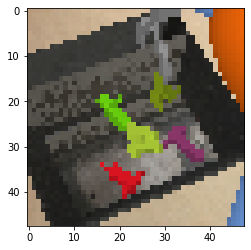

In [4]:
# reset the environment
states = env.reset()
num_agents = 1
# size of each action
action_size = env.action_space.shape[0]
print('Size of each action:', action_size)

# examine the state space 
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape, state_size))
print('The state for the agent looks like:', plt.imshow(states))

In [5]:
device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [61]:
def collect_trajectories(envs, policy, tmax=200, nrand=5, train_mode=False):

    def to_tensor(x, dtype=np.float32):
        x = torch.from_numpy(x)
        print(x.shape)
        x = x.permute(2,0,1) 
        print(x.shape)
        return torch.from_numpy(np.array(x).astype(dtype)).to(device)

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]
    value_list=[]
    done_list=[]

    env_info = envs.reset()

    # perform nrand random steps
    for _ in range(nrand):
        action = np.random.randn(1, action_size)
        action = np.clip(action, -1.0, 1.0)
        next_state, reward, done, info = env.step(action)

    for t in range(tmax):
        next_state=env_info
        states = to_tensor(next_state)
        action_est, values = policy(states.reshape(1,3,48,48))
        sigma = nn.Parameter(torch.zeros(action_size))
        dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        log_probs = torch.sum(log_probs, dim=-1).detach()
        values = values.detach()
        actions = actions.detach()

        env_actions = actions.cpu().numpy()
        env_info = envs.step(env_actions)[brain_name]
        rewards = to_tensor(env_info.rewards)
        dones = to_tensor(env_info.local_done, dtype=np.uint8)

        state_list.append(states.unsqueeze(0))
        prob_list.append(log_probs.unsqueeze(0))
        action_list.append(actions.unsqueeze(0))
        reward_list.append(rewards.unsqueeze(0))
        value_list.append(values.unsqueeze(0))
        done_list.append(dones.unsqueeze(0))
        #if np.any(dones.cpu().numpy()):
        if np.any(dones.numpy()):
            env_info = envs.reset()

    state_list = torch.cat(state_list, dim=0)
    prob_list = torch.cat(prob_list, dim=0)
    action_list = torch.cat(action_list, dim=0)
    reward_list = torch.cat(reward_list, dim=0)
    value_list = torch.cat(value_list, dim=0)
    done_list = torch.cat(done_list, dim=0)
    return prob_list, state_list, action_list, reward_list, value_list, done_list

In [40]:
def calc_returns(rewards, values, dones):
    n_step = len(rewards)
    n_agent = len(rewards[0])

    # Create empty buffer
    GAE = torch.zeros(n_step,n_agent).float().to(device)
    returns = torch.zeros(n_step,n_agent).float().to(device)

    # Set start values
    GAE_current = torch.zeros(n_agent).float().to(device)

    TAU = 0.95
    discount = 0.99
    values_next = values[-1].detach()
    returns_current = values[-1].detach()
    for irow in reversed(range(n_step)):
        values_current = values[irow]
        rewards_current = rewards[irow]
        gamma = discount * (1. - dones[irow].float())

        # Calculate TD Error
        td_error = rewards_current + gamma * values_next - values_current
        # Update GAE, returns
        GAE_current = td_error + gamma * TAU * GAE_current
        returns_current = rewards_current + gamma * returns_current
        # Set GAE, returns to buffer
        GAE[irow] = GAE_current
        returns[irow] = returns_current

        values_next = values_current

    return GAE, returns

## Network Architecture
An actor-critic structure with continuous action space is used for this project. The policy consists of 3 parts, a shared hidden layers, actor, and critic.
The actor layer outputs the mean value of a normal distribution, from which the agent's action is sampled. The critic layer yields the value function.

- Shared layer:
```
Input State(33) -> Dense(128) -> LeakyReLU -> Dense(128) -> LeakyReLU*
```
- Actor and Critic layers:
```
LeakyRelu* -> Dense(64) -> LeakyRelu -> Dense(4)-> tanh -> Actor's output
LeakyReLU* -> Dense(64) -> LeakyRelu -> Dense(1) -> Critic's output
```

### Model update using PPO/GAE
The hyperparameters used during training are:

Parameter | Value | Description
------------ | ------------- | -------------
Number of Agents | 20 | Number of agents trained simultaneously
Episodes | 2000 | Maximum number of training episodes
tmax | 1000 | Maximum number of steps per episode
Epochs | 10 | Number of training epoch per batch sampling
Batch size | 128*20 | Size of batch taken from the accumulated  trajectories
Discount (gamma) | 0.99 | Discount rate 
Epsilon | 0.1 | Ratio used to clip r = new_probs/old_probs during training
Gradient clip | 10.0 | Maximum gradient norm 
Beta | 0.01 | Entropy coefficient 
Tau | 0.95 | tau coefficient in GAE
Learning rate | 2e-4 | Learning rate 
Optimizer | Adam | Optimization method


In [8]:
state_size

48

In [76]:
# run your own policy!
policy=ActorCritic(state_size=state_size,
              action_size=action_size,
              channel_size=3,
              critic_hidden_layers=[],
              actor_hidden_layers=[],
              init_type='xavier-uniform',
              seed=0).to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
optimizer = optim.Adam(policy.parameters(), lr=2e-4)

In [77]:
scores_window = deque(maxlen=100)  # last 100 scores

discount = 0.993
epsilon = 0.07
beta = .01
opt_epoch = 10
episode = 2000
batch_size = 1
tmax = 10 #env episode steps
save_scores = []
print_per_n = min(10,episode/10)
counter = 0
start_time = timeit.default_timer()

for e in range(episode):
    policy.eval()
    old_probs_lst, states_lst, actions_lst, rewards_lst, values_lst, dones_list = collect_trajectories(envs=env,
                                                                                                       policy=policy,
                                                                                                       tmax=tmax,
                                                                                                       nrand = 0,
                                                                                                       train_mode=True)

    avg_score = rewards_lst.sum(dim=0).mean().item()
    scores_window.append(avg_score)
    save_scores.append(avg_score)
    
    gea, target_value = calc_returns(rewards = rewards_lst,
                                     values = values_lst,
                                     dones=dones_list)
    gea = (gea - gea.mean()) / (gea.std() + 1e-8)

    policy.train()

    # cat all agents
    def concat_all(v):
        if len(v.shape) == 3:
            return v.reshape([-1, v.shape[-1]])
        return v.reshape([-1])

    old_probs_lst = concat_all(old_probs_lst)
    states_lst = concat_all(states_lst)
    actions_lst = concat_all(actions_lst)
    rewards_lst = concat_all(rewards_lst)
    values_lst = concat_all(values_lst)
    gea = concat_all(gea)
    target_value = concat_all(target_value)

    # gradient ascent step
    n_sample = len(old_probs_lst)//batch_size
    idx = np.arange(len(old_probs_lst))
    np.random.shuffle(idx)
    for epoch in range(opt_epoch):
        for b in range(n_sample):
            ind = idx[b*batch_size:(b+1)*batch_size]
            g = gea[ind]
            tv = target_value[ind]
            actions = actions_lst[ind]
            old_probs = old_probs_lst[ind]

            action_est, values = policy(states_lst[ind])
            sigma = nn.Parameter(torch.zeros(action_size))
            dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
            log_probs = dist.log_prob(actions)
            log_probs = torch.sum(log_probs, dim=-1)
            entropy = torch.sum(dist.entropy(), dim=-1)

            ratio = torch.exp(log_probs - old_probs)
            ratio_clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            L_CLIP = torch.mean(torch.min(ratio*g, ratio_clipped*g))
            # entropy bonus
            S = entropy.mean()
            # squared-error value function loss
            L_VF = 0.5 * (tv - values).pow(2).mean()
            # clipped surrogate
            L = -(L_CLIP - L_VF + beta*S)
            optimizer.zero_grad()
            # This may need retain_graph=True on the backward pass
            # as pytorch automatically frees the computational graph after
            # the backward pass to save memory
            # Without this, the chain of derivative may get lost
            L.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(policy.parameters(), 10.0)
            optimizer.step()
            del(L)

    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.998
    
    # display some progress every n iterations
    if (e+1)%print_per_n ==0 :
        print("Episode: {0:d}, average score: {1:.2f}".format(e+1,np.mean(scores_window)), end="\n")
    else:
        print("Episode: {0:d}, score: {1:.2f}".format(e+1, avg_score), end="\r")
    if np.mean(scores_window)<5.0:
        counter = 0# stop if any of the trajectories is done to have retangular lists
    if e>=25 and np.mean(scores_window)>30.0:
        print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e+1, np.mean(scores_window)))
        break


print('Average Score: {:.2f}'.format(np.mean(scores_window)))
elapsed = timeit.default_timer() - start_time
print("Elapsed time: {}".format(timedelta(seconds=elapsed)))
print("Saving checkpoint!")
# save your policy!
torch.save(policy.state_dict(), 'checkpoint.pth')

torch.Size([48, 48, 3])
torch.Size([3, 48, 48])


RuntimeError: size mismatch, m1: [1 x 256], m2: [3136 x 512] at /opt/conda/conda-bld/pytorch_1573049306851/work/aten/src/TH/generic/THTensorMath.cpp:197

In [ ]:
def eval_policy(envs, policy, tmax=1000):
    reward_list=[]
    env_info = envs.reset(train_mode=False)[brain_name]
    for t in range(tmax):
        states = torch.from_numpy(env_info.vector_observations).float().to(device)
        action_est, values = policy(states)
        sigma = nn.Parameter(torch.zeros(action_size))
        dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
        actions = dist.sample()
        env_actions = actions.cpu().numpy()
        env_info = envs.step(env_actions)[brain_name]
        reward = env_info.rewards
        dones = env_info.local_done
        reward_list.append(np.mean(reward))

        # stop if any of the trajectories is done to have retangular lists
        if np.any(dones):
            break
    return reward_list

In [ ]:
def update_Q(episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
      #print(state)
      old_Q = Q[state][tuple(np.round(actions[i].flat))]
      Q[state][tuple(np.round(actions[i].flat))] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [ ]:
def generate_episode_from_Q(env, Q, epsilon, nA, height_hack_prob=0.9):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
      env.render(mode='human')
      state_m = tuple(np.round(state.flat))
      action = np.random.choice(np.arange(nA), p=get_probs(Q[state_m], epsilon, nA)) if state_m in Q else action_space.sample()
      if np.random.random() < height_hack_prob:
        action[2] = -1
      if state_m in Q:
        print("*******************From Q!*************************") 
      action_r = np.round(action)
      next_state, reward, done, info = env.step(action_r)
      episode.append((state_m, action_r, reward))
      state = next_state
      if done:
        break
    return episode

In [ ]:
def mc_control(env, num_episodes, alpha, gamma=0.95, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = action_space.shape[0]
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: defaultdict(lambda: np.zeros(nA)))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(episode, Q, alpha, gamma)
        # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [ ]:
policy, Q = mc_control(env, num_episodes=3, alpha=0.1)

In [ ]:
len(policy)

In [ ]:
len(Q)

In [ ]:
print(env.observation_space)